In [ ]:
import gcp.storage as storage
import gcp.bigquery as bq

# Gaps table


In [7]:
%%sql

SELECT COUNT(*) AS count FROM [datalab-projects-1331:xjk_algo_comp.gaps]

count
199386


In [13]:
%%sql --module gaps_histogram

SELECT gap, COUNT(*) AS count FROM [datalab-projects-1331:xjk_algo_comp.gaps]
GROUP BY gap
ORDER BY gap

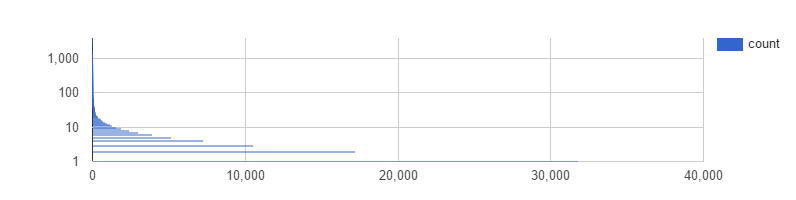

In [15]:
%%chart bars --data gaps_histogram
hAxis:
  title: gap
vAxis:
  logScale: true

Let's go back to some abnormalities we've found earlier, like how there are some timeslots with vastly different number of orders than the rest. Is that pattern prevalent on number of gaps as well? To find this out, we will see how many gaps are there across different timeslots.

In [4]:
%%sql --module gaps_by_timeofday_slot
SELECT timeofday_slot, SUM(gap) AS total_gaps FROM [datalab-projects-1331:xjk_algo_comp.gaps]
GROUP BY timeofday_slot

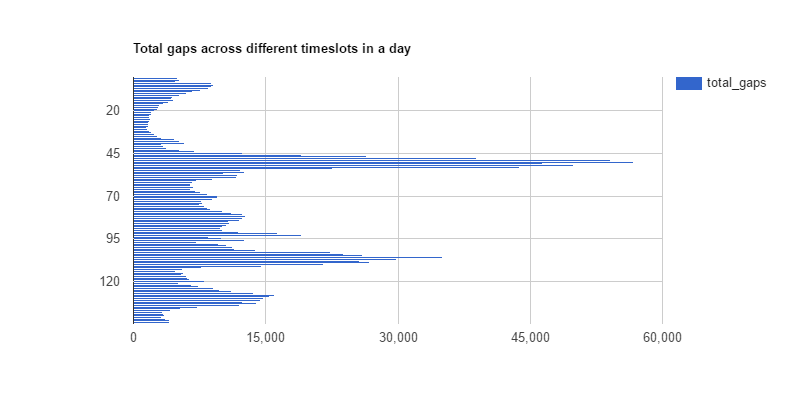

In [5]:
%%chart bars --data gaps_by_timeofday_slot
title: Total gaps across different timeslots in a day
height: 400
vAxis:
  direction: -1

Alright, seems like some timeslots do correlate with higher or lower gaps. This means we do need to include `timeofday_slot` (INTEGER, 1 to 144) as one of our features. Or rather, 144 of our features since we will use one hot encoding on it (explained later).

At this point, I want to see how which variables are correlated with `gap`. The fastest way to do so is by creating a `corrplot` from R:

![corrplot](images/corrplot.png "Corrplot")

(view the image clearer from [this link](https://00e9e64bacf589fc97987b48c75fada18add1af9c197f059ae-apidata.googleusercontent.com/download/storage/v1_internal/b/datalab-projects-1331-datalab/o/others%2Fcorrplot.png?qk=AD5uMEvvogLLi2SD17IZgUMui_oHWpLLD1Xaj-rRHqBK_7V04L8bzHHbvsIEr0XTiZACyxc_FLH02t5xnr7zorQNdVG7JwZERROacXFikIuQAdTvVjOsWoIm1mgNRghTwL2zj-olEGvwtMspEDzOUiNMSC9zrnzeKz8hFWZLhTj_qj0d-nNsmTmmEATDzzHQbmtYwlZIZwdU40dBqSvig7L9kblVmx_VV04NVcglYM8RNxgZVXKPH90HUhK5E-PwLBMWWstdBNHvDyMnley7qU88xK-3OhCLAn7HNtvmIE9M3AAieMsLYb1uNkExqt6KCnSdx2q_93u2i2b2GQhRz4zdECuuYj3KDS6QqoQy-0xmuycvNmAJQzdIY9i2MiH6Yir_WPYVNNRjr-Rb66cw8py-Igpxm-ZdGGFX-c3Lwci8TrNtA2neoCpVbgAYRud8-Q5EEBqvEh_k2RDZJktZDXBSI67iDSMW8W4SRDKR4l_wy47Aht7jI_igebdgCBGoAtTCCAj6rITVf13NqNtLv9qJ8zhYgDXRyAGa4dRPV0kpiLnbbR-VYDmGrznpXjDx-u5hMf5miCt6mluqaMhGjUvjtw9Yd87b1xRJyeUn6qMIM9pHPsH2SjXo7O8sJzoN65FsBRnB2QMK3aVV5jAIFDukudKDkCCcsxF6-S1JxXoPPHQ3B90xSA6rlpAPnpmc4TTXigHtKrtapUhxOXOR7Gn2sKFVogOeAgUnSFfBgFOWy0CYOQF0BDBVyReTCs1EdYEculF8Tvs0cVHn91-z0G03UuLhdmde9OvZWMvMUS0QQLGXVvpFEM9GD88eOwZZ6evAleQouS8r4bDTqoqEsW5ZZK-lZ2aBcEE7K7ICfmMlHMMYw8Ojogc))

Based on the correlation plot we can tell a few things:
1. Past traffic jams, gaps, and sum prices highly correlate with current `gap`.
2. Many of the POIs are moderately correlated with `gap`.
3. Weather conditions do not correlate with `gap`.
4. From this correlation plot, it seems like `timeofday_slot` does not correlate with `gap`. This is however most likely caused by `timeofday_slot` field contains categorical data. We will be able to tell for sure later after we have done one-hot encoding step.

# Problem with exploration

While experimenting with features in this exploration, I found the script runs very slowly when building **gaps** table. I did not focus on making training data building script as effective as possible, instead I worked on it just enough until it is possible to use it for training the model.

# Conclusion

